# ADNI Alzheimer's Neuroiamging Dataset Handling

In [2]:
import os
import shutil
import cv2 as cv
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from tqdm import tqdm
from sklearn.model_selection import train_test_split

We shall unnest the files by gathering each of the file paths as a flattened list.

In [3]:
def join_listdir(a, bs):
    return [os.path.join(a, b) for b in bs]

def list_listdir(dirs, paths=[]):
    return [
        paths + list_listdir(join_listdir(item, os.listdir(item)), paths) if os.path.isdir(item)
        else paths + [item]
        for item in dirs
    ]

def flatten(xs):
    if len(xs) == 0:
        return xs
    if isinstance(xs[0], list):
        return flatten(xs[0]) + flatten(xs[1:])
    return xs[:1] + flatten(xs[1:])

data_dir = "/Data/adni_frmi_alzheimers/data/ADNI_original"
paths = list_listdir([data_dir])
paths = flatten(paths)

Now for each path we can copy to the new target destination.

In [4]:
def get_target_path(path):
    fmri_nii_dir = "/Data/adni_frmi_alzheimers/data/ADNI/fmri_nii"
    meta_xml_dir = "/Data/adni_frmi_alzheimers/data/ADNI/meta_xml"
    filename = os.path.basename(path)
    if filename[-4:] == '.nii':
        return os.path.join(fmri_nii_dir, filename)
    elif filename[-4:] == '.xml':
        return os.path.join(meta_xml_dir, filename)
    print(f"ERROR: unrecognised file type (.{filename.split('.')[1]})")

# for path in tqdm(paths):
#     target_path = get_target_path(path)
#     shutil.copyfile(path, target_path)

As the fMRIs are .nii volumes we will need to convert them to a standard 2D image for training.

Lets see how we can represent them in 2D:

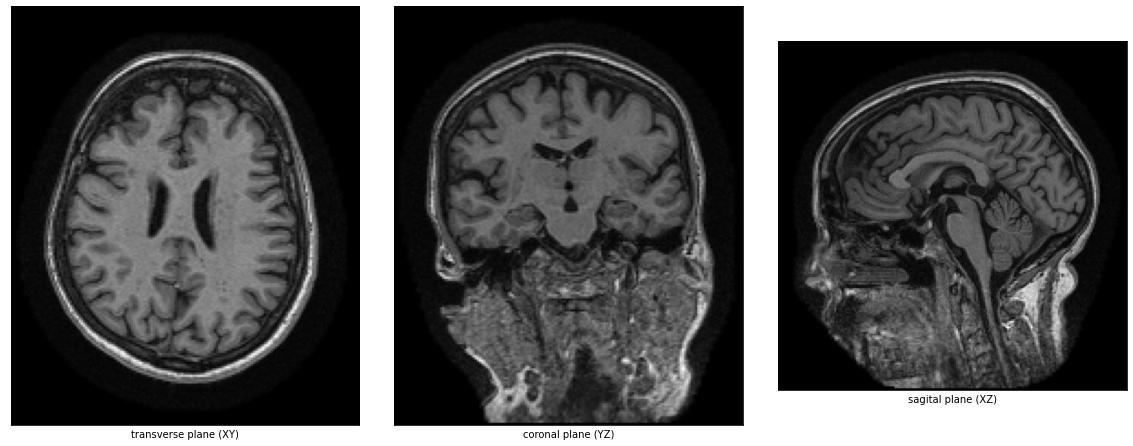

In [5]:
nii_paths = [path for path in paths if path[-4:] == '.nii']
nii_sample = nii_paths[np.random.randint(len(nii_paths))]
nii = nib.load(nii_sample)
volume = nii.get_fdata()

# in transverse plane middle of the brain is ~1/3 depth of XY plane
transverse_slice = ("transverse plane (XY)", volume[volume.shape[0] // 3, :, :]) 
coronal_slice = ("coronal plane (YZ)", volume[:, volume.shape[1] // 2, :])
sagital_slice = ("sagital plane (XZ)", volume[:, :, volume.shape[2] // 2])

fig = plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for i, (plane, img) in enumerate([transverse_slice, coronal_slice, sagital_slice]):
    ax = fig.add_subplot(1, 3, i+1)
    ax.imshow(img, cmap='gray')
    ax.set_xticks([]) 
    ax.set_yticks([])
    ax.set_xlabel(plane)


For now we shall just take the middle slice of each volume.

We will also reshape each to be the minimum size of the dataset and normalise pixel values to (0-255).

In [ ]:
nii_paths = [path for path in paths if path[-4:] == '.nii']
img_dir = "/Data/adni_frmi_alzheimers/data/ADNI/fmri_img/mid_slice/xz_sagital"

# for nii_path in nii_paths:
for nii_path in tqdm(nii_paths):
    nii = nib.load(nii_path)
    volume = nii.get_fdata()
    mid_slice = volume[:, :, volume.shape[2] // 2]
    filename = os.path.basename(nii_path)[:-4] + ".png"
    img_path = os.path.join(img_dir, filename)
    # normalise and ensure all images are 192x192
    if not mid_slice.shape == (192, 192):
        mid_slice = cv.resize(mid_slice, (192, 192))
    mid_slice *= 255 / mid_slice.max()
    cv.imwrite(img_path, mid_slice)
    

Now we shall handle the metadata.

In [11]:
def dict_from_xml(root, path):
    return {
        "subjectIdentifier" : root[0][3][0].text,
        "subjectAge" : float(root[0][3][6][1].text),
        # "ageQualifier" : root[0][3][6][2].text,
        "subjectSex" : root[0][3][2].text,
        "weightKg" : float(root[0][3][6][3].text),
        # "postMortem" : root[0][3][6][4].text,
        "assess_MMSCORE" : float(root[0][3][5][1][0][0].text),
        "assess_GDTOTAL" : float(root[0][3][5][2][0][0].text),
        "assess_CDGLOBAL" : float(root[0][3][5][3][0][0].text),
        "projectIdentifier" : root[0][0].text,
        "studyIdentifier" : root[0][3][6][0].text,
        "visitIdentifier" : root[0][3][5][0].text,
        "researchGroup" : root[0][3][1].text,
        "timestamp" : root[0][3][6][5][3][1][8][5].text,
        "img_id" : os.path.basename(path).split('_')[-1][:-4],
        "fMRI_Name" : os.path.basename(path)[:-4],
    }

meta_dir = "/Data/adni_frmi_alzheimers/data/ADNI/meta_xml"
meta_paths = [os.path.join(meta_dir, path) for path in os.listdir(meta_dir) if path[:4] == "ADNI"]
dicts = []

for path in meta_paths:
    tree = ET.parse(path)
    root = tree.getroot()
    dicts.append(dict_from_xml(root, path))

df = pd.DataFrame(dicts)
df

,subjectIdentifier,subjectAge,subjectSex,weightKg,assess_MMSCORE,assess_GDTOTAL,assess_CDGLOBAL,projectIdentifier,studyIdentifier,visitIdentifier,researchGroup,timestamp,img_id,fMRI_Name
0,002_S_0295,84.9041,M,74.5,28.0,1.0,0.0,ADNI,3566,ADNI Screening,CN,2006-10-07T10:28:02,I118671,ADNI_002_S_0295_MPR__GradWarp__B1_Correction__...
1,002_S_0295,84.9041,M,74.5,28.0,1.0,0.0,ADNI,3566,ADNI Screening,CN,2006-10-07T10:28:02,I45108,ADNI_002_S_0295_MPR__GradWarp__B1_Correction__...
2,002_S_0413,76.3863,F,61.4,29.0,0.0,0.0,ADNI,3697,ADNI Screening,CN,2006-10-07T13:52:02,I118673,ADNI_002_S_0413_MPR__GradWarp__B1_Correction__...
3,002_S_0413,76.3863,F,61.4,29.0,0.0,0.0,ADNI,3697,ADNI Screening,CN,2006-10-07T13:52:02,I45117,ADNI_002_S_0413_MPR__GradWarp__B1_Correction__...
4,002_S_0559,79.3699,M,93.1,30.0,2.0,0.0,ADNI,3978,ADNI Screening,CN,2006-10-07T14:06:02,I118676,ADNI_002_S_0559_MPR__GradWarp__B1_Correction__...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070,073_S_0089,65.1973,M,93.5,30.0,0.0,0.0,ADNI,2957,ADNI Screening,CN,2006-10-10T09:02:03,I119227,ADNI_073_S_0089_MPR-R__GradWarp__B1_Correction...
1071,073_S_0089,65.1973,M,93.5,30.0,0.0,0.0,ADNI,2957,ADNI Screening,CN,2006-10-10T09:02:03,I49675,ADNI_073_S_0089_MPR-R__GradWarp__B1_Correction...
1072,073_S_0311,78.1918,F,79.6,30.0,0.0,0.0,ADNI,4040,ADNI Screening,CN,2006-10-10T09:11:02,I119229,ADNI_073_S_0311_MPR__GradWarp__B1_Correction__...
1073,073_S_0311,78.1918,F,79.6,30.0,0.0,0.0,ADNI,4040,ADNI Screening,CN,2006-10-10T09:11:02,I39868,ADNI_073_S_0311_MPR__GradWarp__B1_Correction__...


Now we can analyse the meta data using Pandas.

In [5]:
print(f"{df['subjectIdentifier'].size} total samples, from {df['subjectIdentifier'].unique().size} subjects.")

1075 total samples, from 818 subjects.


There are quite a few samples from the same patient. As these samples are all from initial screenings it suggests multiple samples are due to errors in the initial sample. For this reason we shall just take the last sample.

In [6]:
subject_ids = df['subjectIdentifier'].tolist()
fmri_names_to_remove = []

for id in subject_ids:
    subject_df = df[df['subjectIdentifier'] == id]['fMRI_Name']
    if len(subject_df) > 1:
        for fmri_name in subject_df.tolist():
            if not "Scaled_2" in fmri_name:
                fmri_names_to_remove.append(fmri_name)

single_df = df[~df.fMRI_Name.isin(fmri_names_to_remove)]
single_df

,subjectIdentifier,subjectAge,subjectSex,weightKg,assess_MMSCORE,assess_GDTOTAL,assess_CDGLOBAL,projectIdentifier,studyIdentifier,visitIdentifier,researchGroup,timestamp,img_id,fMRI_Name
0,002_S_0295,84.9041,M,74.50,28.0,1.0,0.0,ADNI,3566,ADNI Screening,CN,2006-10-07T10:28:02,I118671,ADNI_002_S_0295_MPR__GradWarp__B1_Correction__...
2,002_S_0413,76.3863,F,61.40,29.0,0.0,0.0,ADNI,3697,ADNI Screening,CN,2006-10-07T13:52:02,I118673,ADNI_002_S_0413_MPR__GradWarp__B1_Correction__...
4,002_S_0559,79.3699,M,93.10,30.0,2.0,0.0,ADNI,3978,ADNI Screening,CN,2006-10-07T14:06:02,I118676,ADNI_002_S_0559_MPR__GradWarp__B1_Correction__...
6,002_S_0619,77.5507,M,82.20,22.0,4.0,1.0,ADNI,4059,ADNI Screening,AD,2006-10-07T14:19:02,I118678,ADNI_002_S_0619_MPR-R__GradWarp__N3__Scaled_2_...
8,002_S_0685,89.7370,F,65.30,30.0,2.0,0.0,ADNI,4374,ADNI Screening,CN,2006-10-07T14:21:02,I118680,ADNI_002_S_0685_MPR__GradWarp__B1_Correction__...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066,072_S_1211,86.9589,M,86.18,28.0,3.0,0.5,ADNI,7524,ADNI Screening,MCI,2007-08-02T14:12:40,I119224,ADNI_072_S_1211_MPR____N3__Scaled_2_S27809_I11...
1068,072_S_1380,84.9288,M,96.16,29.0,3.0,0.5,ADNI,8302,ADNI Screening,MCI,2007-07-20T13:25:19,I119226,ADNI_072_S_1380_MPR____N3__Scaled_2_S30046_I11...
1070,073_S_0089,65.1973,M,93.50,30.0,0.0,0.0,ADNI,2957,ADNI Screening,CN,2006-10-10T09:02:03,I119227,ADNI_073_S_0089_MPR-R__GradWarp__B1_Correction...
1072,073_S_0311,78.1918,F,79.60,30.0,0.0,0.0,ADNI,4040,ADNI Screening,CN,2006-10-10T09:11:02,I119229,ADNI_073_S_0311_MPR__GradWarp__B1_Correction__...


Now lets check if there are any duplicates remaining.

In [7]:
print(f"{single_df['subjectIdentifier'].size} total samples, from {single_df['subjectIdentifier'].unique().size} subjects.")

817 total samples, from 817 subjects.


`CDGLOBAL` will be our target.

In [8]:
single_df['assess_CDGLOBAL'].value_counts()

0.5    494
0.0    230
1.0     93
Name: assess_CDGLOBAL, dtype: int64

Lets create seperate dataframes for each.

In [9]:
df_cd00 = single_df[single_df['assess_CDGLOBAL'] == 0.0]
df_cd05 = single_df[single_df['assess_CDGLOBAL'] == 0.5]
df_cd10 = single_df[single_df['assess_CDGLOBAL'] == 1.0]

print(f"cd=0.0: {df_cd00.shape[0]}\ncd=0.5: {df_cd05.shape[0]}\ncd=1.0: {df_cd10.shape[0]}")

cd=0.0: 230
cd=0.5: 494
cd=1.0: 93


There are not many poisitve (1.0) instances so lets explore cd=0.5 and see if we can filter these and find cases to consider positive.

`MMSCORE` represents the score given to a patient in a mini-mental state exam aimed to test congnitive ability. A low score in this indicates congnitive impairment and may be caused by Alzheimer's. Scores of 26 and higher are considered normal, scores of 10-20 indicate moderate dementaia, while score of less than 9 indicate severe impairment.

In [10]:
df_cd05["assess_MMSCORE"].value_counts()

26.0    85
27.0    74
25.0    72
29.0    69
28.0    67
24.0    56
30.0    30
23.0    15
22.0    11
21.0    10
20.0     4
18.0     1
Name: assess_MMSCORE, dtype: int64

5 patients have scores which would be considered indicications of moderate dementia (10-20). As there are only a few cases which fall under moderate we shall omit them considering they are at the lower end of the band.

`GDTOTAL` represents the score attained in a test for geriatric depression. Scores of 0-5 are considered normal and 6-15 are considered depressed. Depression is one of many symptoms of Alzheimer's disease and so high scores in this test may indicate signs of Alzheimer's.

In [11]:
df_cd05["assess_GDTOTAL"].value_counts()

1.0    168
0.0    115
2.0    100
3.0     57
4.0     31
5.0     22
6.0      1
Name: assess_GDTOTAL, dtype: int64

With there only being one result which would be considered depressed we shall ommit adding it to the positive classes considering it is the lowest possible score to be considered depressed.

Now we can create our positive and negative classes.

In [12]:
fmri_img_dir = "/Data/adni_frmi_alzheimers/data/ADNI/fmri_img/mid_slice_side"
fmri_paths = [os.path.join(fmri_img_dir, img_name) for img_name in os.listdir(fmri_img_dir)]

pos_ids = df_cd10["img_id"].tolist()
neg_ids = df_cd00["img_id"].tolist()

pos_paths = [fmri_path for fmri_path in fmri_paths if fmri_path.split('_')[-1][:-4] in pos_ids]
neg_paths = [fmri_path for fmri_path in fmri_paths if fmri_path.split('_')[-1][:-4] in neg_ids]

Now we have the image paths from the `/Data` directory we can gather them and create training, validation and testing sets.

In [13]:
pos_X = [cv.imread(path) for path in pos_paths]
neg_X = [cv.imread(path) for path in neg_paths]

pos_y = [1] * len(pos_X)
neg_y = [0] * len(neg_X)

X = pos_X + neg_X
y = pos_y + neg_y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

Lets compare some samples from the two classes.

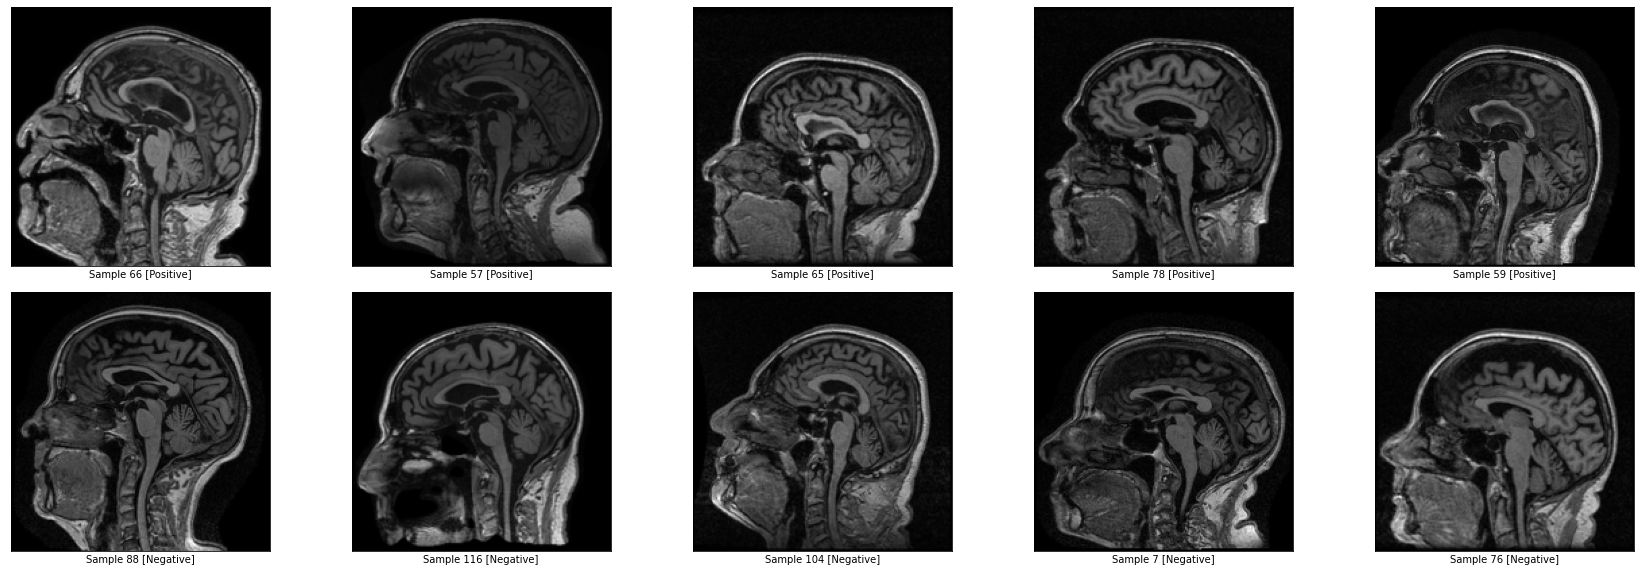

In [19]:
num = 5

pos_samples = [(idx, pos_X[idx]) for idx in np.random.choice(len(pos_X), num)]
neg_samples = [(idx, neg_X[idx]) for idx in np.random.choice(len(neg_X), num)]

fig = plt.figure(figsize=(30, 10))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for i, ((pos_idx, pos_sample), (neg_idx, neg_sample)) in enumerate(zip(pos_samples, neg_samples)):
    # positive samples
    ax = fig.add_subplot(2, num, i + 1)
    ax.imshow(pos_sample, cmap='gray')
    ax.set_xticks([]) 
    ax.set_yticks([])
    ax.set_xlabel("Sample {0} [Positive]".format(pos_idx))
    # negative samples
    ax = fig.add_subplot(2, 5, i + num + 1)
    ax.imshow(neg_sample, cmap='gray')
    ax.set_xticks([]) 
    ax.set_yticks([])
    ax.set_xlabel("Sample {0} [Negative]".format(neg_idx))

We shall move the images to the project directory and organise them so they can be used by the data generator.

In [263]:
def getdirs(classes, data_dir):
    dir_sets = []
    for s in ["train", "val", "test"]:
        dirs = []
        for c in classes:
            dir = "{0}/{1}/".format(s, c)
            dirs.append(os.path.join(data_dir, dir))
        dir_sets.append(dirs)
    return dir_sets

def mkdirs(classes, data_dir):
    dir_sets = getdirs(classes, data_dir)
    for dirs in dir_sets:
        for dir in dirs:
            if not os.path.isdir(dir):    
                os.makedirs(dir)
            else:
                for filepath in os.listdir(dir):
                    os.remove(os.path.join(dir, filepath))
 
def write_imgs(classes, data_dir, X_train, y_train, X_val, y_val, X_test, y_test):
    dir_sets = getdirs(classes, data_dir)
    sets = [(X_train, y_train), (X_val, y_val), (X_test, y_test)]
    for (dirs, (X, y)) in zip(dir_sets, sets):
        counter = [0] * len(classes)
        for (img, label) in zip(X, y):
            filename = "{0}class_{1}_img_{2}.jpg".format(dirs[label], label, counter[label])
            cv.imwrite(filename, img)
            counter[label] += 1


classes = range(2)
data_dir = os.path.join(os.path.join(os.getcwd(), os.pardir), "resources/data/adni_alzheimers")

mkdirs(classes, data_dir)
write_imgs(classes, data_dir, X_train, y_train, X_val, y_val, X_test, y_test)

We shall now gather a set of top slices.

First lets take a single sample and view various depth slices.

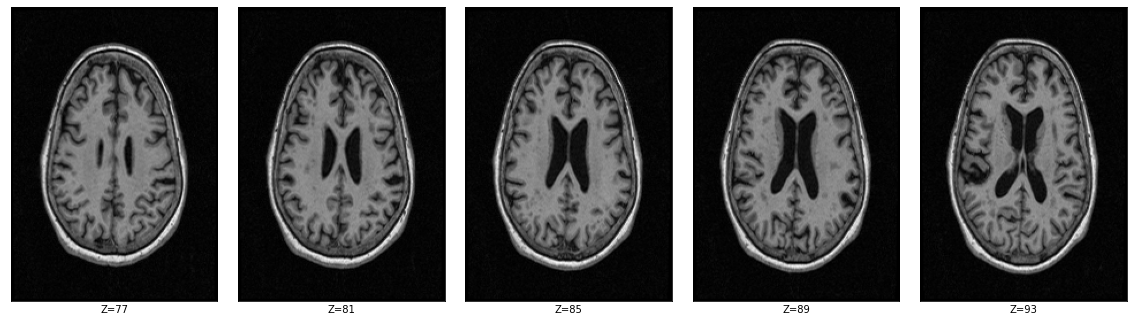

total depth:	256
sample depth:	85 +/- 8
sampled depths:	[77 81 85 89 93]


In [10]:
nii_paths = [path for path in paths if path[-4:] == '.nii']
nii_sample = nii_paths[np.random.randint(len(nii_paths))]

nii = nib.load(nii_sample)
volume = nii.get_fdata()

n = 5
mid_sample_depth = volume.shape[0] // 3
sample_range = mid_sample_depth // 10
sample_depths = np.linspace(mid_sample_depth - sample_range,
                            mid_sample_depth + sample_range, n).astype(int)

transverse_slices = [(depth, volume[depth, :, :]) for depth in sample_depths]

fig = plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for i, (depth, slice) in enumerate(transverse_slices):
    ax = fig.add_subplot(1, n, i+1)
    ax.imshow(slice, cmap='gray')
    ax.set_xticks([]) 
    ax.set_yticks([])
    ax.set_xlabel("Z={0}".format(depth))
plt.show()

print(f"total depth:\t{volume.shape[0]}\nsample depth:\t{mid_sample_depth} +/- {sample_range}\nsampled depths:\t{sample_depths}")

There is a fair amount of variation due to the various placements of the patients head, as well as their size. It would be useful to remove the skull and other non-brain regions. This can be done with external software, but we shall just use the 1/3 depth layer for now.

In [41]:
nii_paths = [path for path in paths if path[-4:] == '.nii']
img_dir = "/Data/adni_frmi_alzheimers/data/ADNI/fmri_img/mid_slice/xy_transverse"

s_256_166 = 0
s_192_160 = 0
s_other = 0

other_sizes = []

# for nii_path in nii_paths:
for nii_path in tqdm(nii_paths):
    nii = nib.load(nii_path)
    volume = nii.get_fdata()
    slice = volume[volume.shape[0] // 3, :, :]
    # filename = os.path.basename(nii_path)[:-4] + ".png"
    # img_path = os.path.join(img_dir, filename)

    if slice.shape == (256, 166):
        s_256_166 += 1
    elif slice.shape == (192, 160):
        s_192_160 += 1
    else:
        s_other += 1
        if not slice.shape in other_sizes:
            other_sizes.append(slice.shape)


            

print(f"\n256x166: {s_256_166}, 192x160: {s_192_160}, other: {s_other}\nother sizes:{other_sizes}")

    # normalise and ensure all images are 192x192
    # if not mid_slice.shape == (192, 192):
        # mid_slice = cv.resize(mid_slice, (192, 192))
    # mid_slice *= 255 / mid_slice.max()
    # cv.imwrite(img_path, mid_slice)

100%|██████████| 1075/1075 [03:56<00:00,  4.55it/s]
256x166: 349, 192x160: 402, other: 324
other sizes:[(256, 180), (256, 170), (256, 160), (256, 146), (256, 162), (256, 161), (256, 184)]



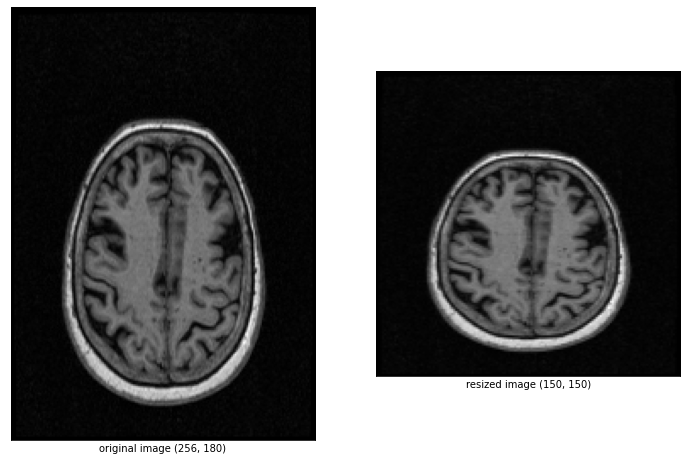

In [39]:
nii_path = nii_paths[np.random.randint(len(nii_paths))]

nii = nib.load(nii_path)
volume = nii.get_fdata()
slice = volume[volume.shape[0] // 3, :, :]

filename = os.path.basename(nii_path)[:-4] + ".png"
img_path = os.path.join(img_dir, filename)

img = cv.resize(slice, (150, 150))

fig = plt.figure(figsize=(12, 8))
for i, (output, tag) in enumerate([(slice, "original"), (img, "resized")]):
    ax = fig.add_subplot(1, 2, i+1)
    ax.imshow(output, cmap='gray')
    ax.set_xticks([]) 
    ax.set_yticks([])
    ax.set_xlabel("{0} image {1}".format(tag, output.shape))
plt.show()